In [4]:
# Std lib:
import warnings
import os

# apriori algorithm lib
from apyori import apriori

# To hide environment variables
from dotenv import load_dotenv

# Data manipulation:
import numpy as np
import pandas as pd
import geopandas
from shapely.geometry import Point, Polygon

# Visualization:
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
%matplotlib inline
style.use('seaborn')

# Display all columns in Jupyter:
from IPython.display import display
pd.options.display.max_columns = None
pd.set_option('display.max_colwidth', None)

# Filter Warnings
warnings.filterwarnings('ignore')

# Load Data

In [5]:
datatypes = {'block': 'object',
             'iucr': 'object',
             'primary_type': 'object',
             'description': 'object',
             'location_description': 'object',
             'arrest': 'bool',
             'domestic': 'bool',
             'beat': 'int64',
             'district': 'float64',
             'ward': 'float64',
             'community_area': 'int64',
             'fbi_code': 'object',
             'x_coordinate': 'float64',
             'y_coordinate': 'float64',
             'year': 'int64',
             'latitude': 'float64',
             'longitude': 'float64',
             'location': 'object',
             'month': 'uint8',
             'hour': 'uint8',
             'dayofweek': 'uint8',
             'weekend': 'bool',
             'CF': 'float64',
             'CF3': 'float64',
             'PI': 'float64',
             'EUH': 'float64',
             'CH': 'float64',
             'SOI': 'float64',
             'crime_code_category': 'category',
             'index_crime': 'bool',
             'violent_crime': 'bool',
             'property_crime': 'bool',
             'crime_against_persons': 'bool',
             'crime_against_property': 'bool',
             'crime_against_society': 'bool'}

In [6]:
%%time
load_dotenv()
path_to_data = os.environ.get('CLEAN_DATA')
df = pd.read_csv(path_to_data, dtype=datatypes)

CPU times: user 40.5 s, sys: 5.75 s, total: 46.3 s
Wall time: 50.7 s


# Prepare Data for Mining

#### Filter out attributes that will not be considered for frequent itemset analysis

In [7]:
attributes = [ "crime_against_persons", "crime_against_property", "crime_against_society", \
              "location_description", "description", "crime_code_category", "arrest", \
              "domestic", "district", "ward", "community_area", "index_crime", "beat", \
              "violent_crime", "month", "hour", "dayofweek", "weekend", "block", "year"]

data = df[attributes]

#### Remove extraneous address characters from 'block' attribute to validate its use in frequent itemset mining

In [8]:
%%time
data['block'] = data['block'].str[6:]
data['block'].head()

CPU times: user 1.87 s, sys: 129 ms, total: 2 s
Wall time: 2.01 s


0                        E 84TH ST
1                        W 57TH ST
2                         S MAY ST
3                  S BALTIMORE AVE
4    S DR MARTIN LUTHER KING JR DR
Name: block, dtype: object

#### Convert column values to numbers to speed up frequent itemset mining

In [9]:
%%time
###### BEWARE -- 12+ min to run this block. 

data_num = data.copy()
val_dict = {}
index = 0

for attribute in attributes:
    # Important! Reset so column vals don't cross-pollinate:
    num_dict = {}
    
    # Get all unique values for column:
    values = pd.unique(data[attribute])
    
    # For each unique value replace with an index no.
    for value in values:
        # add index no. as key to value for later reference:
        val_dict[index] = (attribute, value)
        num_dict[value] = index
        index += 1
    # Replace per column to avoid cross-pollination.
    data_num[attribute] = data_num[attribute].replace(num_dict)
    
######

# verify results
data_num.head()

CPU times: user 17min 1s, sys: 1min 6s, total: 18min 8s
Wall time: 18min 19s


,crime_against_persons,crime_against_property,crime_against_society,location_description,description,crime_code_category,arrest,domestic,district,ward,community_area,index_crime,beat,violent_crime,month,hour,dayofweek,weekend,block,year
0,0,2,4,6,220,748,774,776,778.0,802.0,852,930,932,1235,1237,1249,1273,1280,1282,4577
1,0,2,4,7,221,748,775,776,779.0,803.0,853,930,933,1235,1237,1250,1274,1280,1283,4577
2,0,2,4,8,221,748,775,776,780.0,804.0,854,930,934,1235,1237,1251,1275,1280,1284,4577
3,0,2,4,7,220,748,774,776,778.0,805.0,852,930,935,1235,1237,1252,1275,1280,1285,4577
4,0,2,4,9,221,748,774,777,781.0,806.0,855,930,936,1235,1237,1253,1276,1281,1286,4577


In order to use the apyori library, we will need to be able to convert dataframes into list of lists:

In [10]:
def convert_df_2_list(df):
    return df.to_numpy().tolist()

As also need a means of formatting and returning our results as a dataframe with human-readable data:

In [11]:
def df_results(association_results):
    
    dataframes = []
    for rule in association_results:
        data = {}
        
        # create a rule from results
        base = list(rule[2][0][0])
        base = [val_dict[b][1] for b in base]
        add = list(rule[2][0][1])
        add = val_dict[add[0]][1]
        data['rule'] = str(base) + ' ==> ' + str(add)

        # support, confidence, and lift of rule
        data['lift'] = rule[2][0][3]
        data['confidence'] = rule[2][0][2]
        data['support'] = rule[1]

        # components of rule
        for item in rule[0]:
            data[val_dict[item][0]] = val_dict[item][1]
        
        # convert rules to dataframe rows
        dataframe = pd.DataFrame.from_records([data])
        dataframes.append(dataframe)
    
        # concat rules as rows of single dataframe
    if not dataframes:
        return "No results."
    return pd.concat(dataframes, ignore_index=True, axis=0)

In [12]:
def df_results_simple(association_results):
    
    dataframes = []
    for rule in association_results:
        data = {}
        
        # create a rule from results
        base = list(rule[2][0][0])
        base = [val_dict[b] for b in base]
        add = list(rule[2][0][1])
        add = val_dict[add[0]]
        data['rule'] = str(base) + ' ==> ' + str(add)

        # support, confidence, and lift of rule
        data['lift'] = rule[2][0][3]
        data['confidence'] = rule[2][0][2]
        data['support'] = rule[1]
        
        # convert rules to dataframe rows
        dataframe = pd.DataFrame.from_records([data])
        dataframes.append(dataframe)
    
        # concat rules as rows of single dataframe
    if not dataframes:
        return "No results."
    return pd.concat(dataframes, ignore_index=True, axis=0)

And finally we want a wrapper function that converts the dataframe, applies the apriori class, and converts the results to a dataframe:

In [13]:
def use_apriori(df, supp, conf, lift):
    records = convert_df_2_list(df)
    association_rules = apriori(records, min_support=supp, min_confidence=conf, min_lift=lift)
    association_results = list(association_rules)
    return df_results(association_results)

In [14]:
def use_apriori_simple(df, supp, conf, lift):
    records = convert_df_2_list(df)
    association_rules = apriori(records, min_support=supp, min_confidence=conf, min_lift=lift)
    association_results = list(association_rules)
    return df_results_simple(association_results)

CITATION:
Regarding use of the apyori lib see our references here:
- https://github.com/ymoch/apyori
- https://stackabuse.com/association-rule-mining-via-apriori-algorithm-in-python/
- pydoc entry:<br>
    ```
    apyori.apriori = apriori(transactions, **kwargs)
        Executes Apriori algorithm and returns a RelationRecord generator.

        Arguments:
            transactions -- A transaction iterable object
                            (eg. [['A', 'B'], ['B', 'C']]).

        Keyword arguments:
            min_support -- The minimum support of relations (float).
            min_confidence -- The minimum confidence of relations (float).
            min_lift -- The minimum lift of relations (float).
            max_length -- The maximum length of the relation (integer).
    ```

# Parameters and Apriori

#### Identify interesting subsets of the data

Because we have chosen twenty attributes to mine for frequent itemsets, many of which have vary in form and frequency, it would be impractical to mine them all at once. Instead we need to select subsets of our attributes. However, with twenty total attributes we have 1,048,575 possible combinations. So, we need to be selective. 
<br><br>
There are several ways we can look at our attributes when deciding which to combine. One is to look at the the number of unique values each attribute contains. This has the added benefit of helping us later when we are setting the minimum support, confidence, and lift values as parameters to the apriori algorithm. Even better, we can also take a look at how often the two least frequent unique values occur, which will give us a major clue how low we may need to lower the minimum support in order for certain unique values to not be automatically omitted from our results. Given that we have 6,508,416 rows of data total, if some of these attributes have very low frequency counts for unique values, then that means we may need to work our way down to very low support levels for certain columns in order to reveal certain frequent itemsets that may still have high confidence and lift. 

In [15]:
unq, frq1, frq2, perc1, perc2 = [], [], [], [], []
for attribute in attributes:
    unq.append(len(pd.unique(data[attribute])))
    f1 = data[attribute].value_counts(ascending=True).iloc[0]
    frq1.append(f1)
    f2 = data[attribute].value_counts(ascending=True).iloc[1]
    frq2.append(f2)
    perc1.append(str(round((f1 / 6508416)*100,4)) + '%')
    perc2.append(str(round((f2 / 6508416)*100,4)) + '%')
display(pd.DataFrame({'attributes': attributes, 'unique vals': unq, \
                      'count least frequent': frq1, \
                      '% of total': perc1, \
                      'count 2nd least': frq2, \
                      '2nd % of total': perc2} \
                    ).set_index('attributes').sort_values(by=['unique vals']))

,unique vals,count least frequent,% of total,count 2nd least,2nd % of total
attributes,,,,,
crime_against_persons,2,1713049,26.3205%,4795367,73.6795%
crime_against_property,2,3200474,49.1744%,3307942,50.8256%
crime_against_society,2,1543323,23.7127%,4965093,76.2873%
weekend,2,1817210,27.9209%,4691206,72.0791%
arrest,2,1762303,27.0773%,4746113,72.9227%
domestic,2,881185,13.5392%,5627231,86.4608%
violent_crime,2,565845,8.6941%,5942571,91.3059%
index_crime,2,2622479,40.2937%,3885937,59.7063%
dayofweek,7,884921,13.5966%,918481,14.1122%



Finally, another way we can also look at the different attributes to decide what combinations will be most useful is in terms of what information they provide given the context. By doing that, we can roughly divide them into three groups: the WHAT, WHERE, and WHEN of a crime. 

| WHAT | WHERE | WHEN |
|:------|:-------|:------|
|crime_against_persons|district|month|
|crime_against_property|ward|hour|
|description|community_area|dayofweek|
|location_description|beat|weekend|
|crime_code_category|block|year|
|arrest|||
|domestic|||
|index_crime|||
|violent_crime|||

With this information in hand, we can make some more informed decisions about what subsets will be the most salient and/or provide the best results due to similarities in the unique value counts and contextual differences and similarities. We will want to avoid including attributes that are too similar to each other, or otherwise overlap, while also avoid using attributes together that are too different in terms of their unique items counts.<br>
<br>
Using these criteria to narrow data subsets down, we define the list of candidates we will consider here:

In [16]:
##### Create dataframe subsets for frequent itemset mining

bk_dn = data_num[["block", "description"]]
bk_ld = data_num[["block", "location_description"]]
bt_dn = data_num[["beat", "description"]]
bt_ld = data_num[["beat", "location_description"]]
ld_dn = data_num[["description", "location_description"]]
ca_dn = data_num[["community_area", "description"]]
ca_ld = data_num[["community_area", "location_description"]]
ca_hr = data_num[["community_area", "hour"]]
ld_ca_ccc = data_num[["community_area", "location_description", "crime_code_category"]]
ca_cape_capo_cas = data_num[["community_area", "crime_against_persons", "crime_against_property", "crime_against_society"]]
ld_cape_capo_cas = data_num[["location_description", "crime_against_persons", "crime_against_property", "crime_against_society"]]
wkn_cape_capo_cas = data_num[["weekend", "crime_against_persons", "crime_against_property", "crime_against_society"]]
hr_cape_capo_cas = data_num[["hour", "crime_against_persons", "crime_against_property", "crime_against_society"]]
arr_dom_idx_vc = data_num[["arrest", "domestic", "index_crime", "violent_crime"]]
ca_cape_capo_cas_arr = data_num[["community_area", "crime_against_persons", "crime_against_property", "crime_against_society", "arrest"]]
ca_arr_dom_idx_vc = data_num[["community_area", "arrest", "domestic", "index_crime", "violent_crime"]]
ccc_hr_yr_mon_dow_dc = data_num[["crime_code_category", "hour", "year", "month", "dayofweek", "district"]]
ccc_hr_yr_mon_dow_wd = data_num[["crime_code_category", "hour", "year", "month", "dayofweek", "ward"]]
ccc_hr_yr_mon_dow_ca = data_num[["crime_code_category", "hour", "year", "month", "dayofweek", "community_area"]]

#####

#### Applying Apriori
Finally, with the subsets of data we want to explore the most prepared, we can begin iteratively applying our application of the apriori alogorithm, adjusting the parameters as we go, in pursuit of interesting information. The final forumula for applying the apriori to a subset of the data is provided here, using the ld_ca_ccc data subset as our example:

In [17]:
%%time
####### final formula for frequent itemset mining

# adjustable parameters:
dataframe_to_analyze = ld_ca_ccc
minimum_support = 0.0045
minimum_confidence = 0.2
minimum_lift = 3

# convert dataframe to consumable list of lists, apply apriori to identify frequent itemsets, and print results:
demo_results = use_apriori(dataframe_to_analyze, minimum_support, minimum_confidence, minimum_lift)
print(demo_results.shape[0], "rules found.")
print()

# display results
demo_results.sort_values(by=['lift', 'confidence', 'support'], ascending=False)

#######

8 rules found.

CPU times: user 22.9 s, sys: 966 ms, total: 23.9 s
Wall time: 24.1 s


,rule,lift,confidence,support,crime_code_category,location_description,community_area
6,['RESIDENCE-GARAGE'] ==> Burglary,8.856286,0.505816,0.009495,Burglary,RESIDENCE-GARAGE,NaN
7,"[25, 'SIDEWALK'] ==> Drug Abuse",4.930013,0.468830,0.005493,Drug Abuse,SIDEWALK,25.0
5,['DEPARTMENT STORE'] ==> Larceny,3.866943,0.819444,0.010368,Larceny,DEPARTMENT STORE,NaN
3,['Prostitution'] ==> STREET,3.197930,0.819378,0.007665,Prostitution,STREET,NaN
0,['SIDEWALK'] ==> Drug Abuse,3.182014,0.302601,0.030520,Drug Abuse,SIDEWALK,NaN
1,['Robbery'] ==> SIDEWALK,3.149042,0.317610,0.011989,Robbery,SIDEWALK,NaN
2,['Motor Vehicle Theft'] ==> STREET,3.074678,0.787798,0.035736,Motor Vehicle Theft,STREET,NaN
4,['GROCERY FOOD STORE'] ==> Larceny,3.025541,0.641142,0.008058,Larceny,GROCERY FOOD STORE,NaN


# Results
Applying the apriori algorithm is an extremely iterative process. Besides the many, many different subsets of data we can choose from, there is an almost infinite number of tweaks that can be made to the minimum support, minimum confidence, and minimum lift parameters for each one. Each results must then be interpreted by human user to analyze the validity, usefulness, and interestingness. Furthermore, it must be noted that there will always be inherent biases in the data, hence there will be biases in the results. Whether that bias is due to some information that is missing, or bias in how the information itself was originally gathered, we cannot take any results as a penultimate truth. The results shown below are therefore not exhaustive, and only meant to show some of the more interesting results we found and only a small sliver of what is possible. The parameters for each result provided below has been fine tuned for each case, but in each case other possibilities exist depending on the information that one wants to show. Copy and paste these into the Sandbox section to make adjustments and drill down on information you would like to explore further. 

### 1. block, description

In [18]:
%%time
####### final formula for frequent itemset mining

# adjustable parameters:
dataframe_to_analyze = bk_dn
minimum_support = 0.0002
minimum_confidence = 0.1
minimum_lift = 3

# convert dataframe to consumable list of lists, apply apriori to identify frequent itemsets, and print results:
bk_dn_results = use_apriori(dataframe_to_analyze, minimum_support, minimum_confidence, minimum_lift)
print(bk_dn_results.shape[0], "rules found.")
print()

# display results
bk_dn_results.sort_values(by=['lift', 'confidence', 'support'], ascending=False)

#######

23 rules found.

CPU times: user 56.6 s, sys: 780 ms, total: 57.3 s
Wall time: 57.7 s


,rule,lift,confidence,support,block,description
1,['OTHER WEAPONS VIOLATION'] ==> W OHARE ST,117.671496,0.290562,0.000337,W OHARE ST,OTHER WEAPONS VIOLATION
2,['THEFT OF LABOR/SERVICES'] ==> W LAKE ST,37.316811,0.144871,0.000633,W LAKE ST,THEFT OF LABOR/SERVICES
0,['TO STATE SUP LAND'] ==> S STATE ST,14.498915,0.166894,0.000827,S STATE ST,TO STATE SUP LAND
22,['SOLICIT ON PUBLIC WAY'] ==> W MADISON ST,14.217900,0.130011,0.000836,W MADISON ST,SOLICIT ON PUBLIC WAY
17,['N STATE ST'] ==> RETAIL THEFT,12.513562,0.352713,0.001897,N STATE ST,RETAIL THEFT
16,['N MICHIGAN AVE'] ==> RETAIL THEFT,10.849634,0.305812,0.001479,N MICHIGAN AVE,RETAIL THEFT
18,['S CANAL ST'] ==> RETAIL THEFT,7.354911,0.207309,0.000370,S CANAL ST,RETAIL THEFT
10,['W 87TH ST'] ==> RETAIL THEFT,7.315513,0.206198,0.000596,W 87TH ST,RETAIL THEFT
9,['E GRAND AVE'] ==> RETAIL THEFT,7.036304,0.198328,0.000201,E GRAND AVE,RETAIL THEFT
7,['W HOWARD ST'] ==> RETAIL THEFT,7.009306,0.197567,0.000257,W HOWARD ST,RETAIL THEFT


This data subset has quite a few results, all with very high lift. The majority of the results are Retail Theft, which might typically mean that it is simply the most common and so is over-represented in the results, however the high lift in this case tells us two things: the majority of Retail Theft is occurring off these streets and the majority of crime in these streets is retail theft. This is in large part because of how small these streets are, and the fact that they are concentrated in retail areas around malls and department store centers. The major outlier though is not retail theft, but actually 'Other Weapons Violation' => West O'Hare St. This is extremely interesting given how high the lift is compared to everything else. Looking into this result, we find that West O'Hare St is a very small street at the O'Hare airport. Suddenly we can guess what is happening here. Most likely 'Other Weapons Violation' describes crime where individuals are carrying dangerous items disallowed on planes, who are likely getting caught at security. This indicates a bias in the data created by the unique circumstances of the airport that exist nowhere else in the city, resulting in the unusually high association between the crime description and block. 

### 2. block, location_description

In [19]:
%%time
####### final formula for frequent itemset mining

# adjustable parameters:
dataframe_to_analyze = bk_ld
minimum_support = 0.0002
minimum_confidence = 0.2
minimum_lift = 3

# convert dataframe to consumable list of lists, apply apriori to identify frequent itemsets, and print results:
bk_ld_results = use_apriori_simple(dataframe_to_analyze, minimum_support, minimum_confidence, minimum_lift)
print(bk_ld_results.shape[0], "rules found.")
print()

# display results
bk_ld_results.sort_values(by=['lift', 'confidence', 'support'], ascending=False)

#######

30 rules found.

CPU times: user 1min, sys: 719 ms, total: 1min 1s
Wall time: 1min 1s


,rule,lift,confidence,support
28,"[('location_description', 'AIRPORT TERMINAL LOWER LEVEL - NON-SECURE AREA')] ==> ('block', 'W TERMINAL ST')",942.652111,0.747788,0.000208
29,"[('location_description', 'AIRPORT TERMINAL UPPER LEVEL - SECURE AREA')] ==> ('block', 'W TERMINAL ST')",486.553445,0.385973,0.000245
27,"[('location_description', 'AIRPORT/AIRCRAFT')] ==> ('block', 'W OHARE ST')",319.268758,0.788359,0.001590
25,"[('block', 'E HURON ST')] ==> ('location_description', 'HOSPITAL BUILDING/GROUNDS')",156.218304,0.483290,0.000202
24,"[('block', 'W FILLMORE ST')] ==> ('location_description', 'POLICE FACILITY/VEH PARKING LOT')",124.201609,0.320503,0.000317
22,"[('block', 'E WACKER DR')] ==> ('location_description', 'HOTEL/MOTEL')",100.134314,0.410697,0.000257
9,"[('block', 'S FEDERAL ST')] ==> ('location_description', 'CHA PARKING LOT/GROUNDS')",62.349271,0.430401,0.000594
10,"[('block', 'E BROWNING AVE')] ==> ('location_description', 'CHA PARKING LOT/GROUNDS')",58.358692,0.402854,0.000204
23,"[('block', 'W LAKE ST')] ==> ('location_description', 'CTA PLATFORM')",43.967030,0.227570,0.000883
17,"[('block', 'W PRYOR AVE')] ==> ('location_description', 'SCHOOL, PUBLIC, BUILDING')",36.600302,0.738938,0.000205


Once again, we have EXTREMELY high lift for a few items due to the fact that they are occuring at the airport. Generally speaking, there is some overlap between 'block' and 'location_description' due to the block being a very small street specific to an institution, such as hospitals, schools, airports, or otherwise, which then of course appear in the description. However, there are still some very interesting results that crop up in what we might have otherwise considered a redundant combination. For example, we find a very high crime association between E. Wacker St and Hotels, as well as a very strong association between crime on a slew of streets and their apartments. Finally, there is a strong correlation between a few streets and some parking garages located off of them. This is potentially useful information in that it very strongly identifies the source of a lot of crime on these streets, which may help law enforcement or perhaps community building programs focus their resources and efforts in improving or securing what is likely source of a significant portion of crime in these locations. 

### 3. beat, description

In [20]:
%%time
####### final formula for frequent itemset mining

# adjustable parameters:
dataframe_to_analyze = bt_dn
minimum_support = 0.0002
minimum_confidence = 0.1
minimum_lift = 3

# convert dataframe to consumable list of lists, apply apriori to identify frequent itemsets, and print results:
bt_dn_results = use_apriori(dataframe_to_analyze, minimum_support, minimum_confidence, minimum_lift)
print(bt_dn_results.shape[0], "rules found.")
print()

# display results
bt_dn_results.sort_values(by=['lift', 'confidence', 'support'], ascending=False)

#######

36 rules found.

CPU times: user 43.6 s, sys: 795 ms, total: 44.4 s
Wall time: 44.7 s


,rule,lift,confidence,support,beat,description
4,['OTHER WEAPONS VIOLATION'] ==> 1651,151.735183,0.377519,0.000438,1651,OTHER WEAPONS VIOLATION
2,['TO STATE SUP LAND'] ==> 134,47.509529,0.124372,0.000617,134,TO STATE SUP LAND
1,['TO STATE SUP LAND'] ==> 1823,33.944391,0.105467,0.000523,1823,TO STATE SUP LAND
3,[2113] ==> TO STATE SUP LAND,27.143479,0.134566,0.000282,2113,TO STATE SUP LAND
5,[1114] ==> THEFT OF LABOR/SERVICES,25.480635,0.111339,0.000300,1114,THEFT OF LABOR/SERVICES
35,[1113] ==> SOLICIT ON PUBLIC WAY,20.402388,0.131143,0.000596,1113,SOLICIT ON PUBLIC WAY
22,[1833] ==> RETAIL THEFT,9.927872,0.279831,0.001243,1833,RETAIL THEFT
0,[1121] ==> POSS: HEROIN(WHITE),8.278021,0.107913,0.000585,1121,POSS: HEROIN(WHITE)
13,[122] ==> RETAIL THEFT,7.253704,0.204456,0.001086,122,RETAIL THEFT
12,[622] ==> RETAIL THEFT,6.409896,0.180672,0.000566,622,RETAIL THEFT


The beat + description results have quite a few results with reasonably high lift, however they are dominated by the most common descriptions. This is fair in it it's representation of the majority of crime a given beat will face, but is not super interesting. However, we do see three beats that are interesting, where given the beat there is a strong association with THEFT OF LABOR/SERVICES, SOLICIT ON PUBLIC WAY, and POSS: HEROIN(WHITE) (ignoring the other weapons violation discussed previously). This is significant in that it indicates these crime descriptions exceed even the most common ones, which may mean these beats warrant additional resources specific to combating these types of crime. They may also entail endemic crime issues above and beyond the norm. 

### 4. beat, location_description

In [21]:
%%time
####### final formula for frequent itemset mining

# adjustable parameters:
dataframe_to_analyze = bt_ld
minimum_support = 0.0002
minimum_confidence = 0.15
minimum_lift = 3

# convert dataframe to consumable list of lists, apply apriori to identify frequent itemsets, and print results:
bt_ld_results = use_apriori(dataframe_to_analyze, minimum_support, minimum_confidence, minimum_lift)
print(bt_ld_results.shape[0], "rules found.")
print()

# display results
bt_ld_results.sort_values(by=['lift', 'confidence', 'support'], ascending=False)

#######

17 rules found.

CPU times: user 38.9 s, sys: 735 ms, total: 39.7 s
Wall time: 39.8 s


,rule,lift,confidence,support,beat,location_description
15,['AIRPORT TERMINAL UPPER LEVEL - SECURE AREA'] ==> 1653,857.367617,0.355018,0.000226,1653,AIRPORT TERMINAL UPPER LEVEL - SECURE AREA
14,['AIRPORT/AIRCRAFT'] ==> 1651,317.322660,0.789502,0.001592,1651,AIRPORT/AIRCRAFT
16,['AIRPORT TERMINAL UPPER LEVEL - SECURE AREA'] ==> 1651,132.193890,0.328900,0.000209,1651,AIRPORT TERMINAL UPPER LEVEL - SECURE AREA
4,['CHA HALLWAY/STAIRWELL/ELEVATOR'] ==> 134,90.886707,0.237927,0.000745,134,CHA HALLWAY/STAIRWELL/ELEVATOR
12,['POLICE FACILITY/VEH PARKING LOT'] ==> 1134,45.845452,0.185948,0.000480,1134,POLICE FACILITY/VEH PARKING LOT
3,[2113] ==> CHA PARKING LOT/GROUNDS,44.227454,0.305305,0.000639,2113,CHA PARKING LOT/GROUNDS
13,['AIRPORT/AIRCRAFT'] ==> 813,35.336605,0.176444,0.000356,813,AIRPORT/AIRCRAFT
10,[533] ==> CHA APARTMENT,34.110671,0.155480,0.000673,533,CHA APARTMENT
1,[1823] ==> CHA PARKING LOT/GROUNDS,29.858076,0.206112,0.000640,1823,CHA PARKING LOT/GROUNDS
9,['HOTEL/MOTEL'] ==> 1834,26.296929,0.178729,0.000733,1834,HOTEL/MOTEL


Many of the same biases in beat + location also appear here, in beat + location_description. Again, a few interesting results do also appear. For example, if a crime happens in a hallway/stairwell, it is likely in beat 134. Is that a bias due to a characteristic of the beat having more scyscrapers? Or, is there another cause? Also, a crime in beat 114 and beat 2023 typically means a crime in a park and a grocery store, respectively. Likewise, additional information on the beat would need to be conducted to understand why and whether this is actually interesting information we can use or not. It should be noted that of the 17 results we show here, not one is below a lift of 9!!! This indicates we may have many more interesting results and that further exploration given this data subset is warranted. 

### 5. location, location_description

In [22]:
%%time
####### final formula for frequent itemset mining

# adjustable parameters:
dataframe_to_analyze = ld_dn
minimum_support = 0.0045
minimum_confidence = 0.2
minimum_lift = 3

# convert dataframe to consumable list of lists, apply apriori to identify frequent itemsets, and print results:
ld_dn_results = use_apriori(dataframe_to_analyze, minimum_support, minimum_confidence, minimum_lift)
print(ld_dn_results.shape[0], "rules found.")
print()

# display results
ld_dn_results.sort_values(by=['lift', 'confidence', 'support'], ascending=False)

#######

14 rules found.

CPU times: user 11 s, sys: 513 ms, total: 11.5 s
Wall time: 11.5 s


,rule,lift,confidence,support,description,location_description
12,['DEPARTMENT STORE'] ==> RETAIL THEFT,23.781002,0.670302,0.008481,RETAIL THEFT,DEPARTMENT STORE
10,['GROCERY FOOD STORE'] ==> RETAIL THEFT,17.425472,0.491162,0.006173,RETAIL THEFT,GROCERY FOOD STORE
11,['SMALL RETAIL STORE'] ==> RETAIL THEFT,13.839598,0.390089,0.007240,RETAIL THEFT,SMALL RETAIL STORE
13,['RESIDENCE-GARAGE'] ==> FORCIBLE ENTRY,8.130278,0.311899,0.005855,FORCIBLE ENTRY,RESIDENCE-GARAGE
5,['HARASSMENT BY TELEPHONE'] ==> RESIDENCE,3.885642,0.645891,0.009179,HARASSMENT BY TELEPHONE,RESIDENCE
3,['STRONGARM - NO WEAPON'] ==> SIDEWALK,3.819931,0.385275,0.004972,STRONGARM - NO WEAPON,SIDEWALK
1,['POSS: HEROIN(WHITE)'] ==> SIDEWALK,3.670087,0.370162,0.004825,POSS: HEROIN(WHITE),SIDEWALK
4,['TELEPHONE THREAT'] ==> RESIDENCE,3.657308,0.607936,0.011881,TELEPHONE THREAT,RESIDENCE
0,['POSS: CANNABIS 30GMS OR LESS'] ==> SIDEWALK,3.398139,0.342733,0.013527,POSS: CANNABIS 30GMS OR LESS,SIDEWALK
7,['SOLICIT ON PUBLIC WAY'] ==> STREET,3.295824,0.844460,0.005428,SOLICIT ON PUBLIC WAY,STREET


While we might expect the location and location_description data series to be redundant, and in fact they are, the results are still fairly interesting. As we will see later, burglary is the most common crime occuring in residence garages, however we see here that these are largely due to forced entries, which may be valuable information for those looking to protect their homes. Similarly, we see that when robberies occur on the sidewalk they are typically unarmed, which may be surprising. We also see that most crime committed in an apartment is simple domestic battery. This kind of information is especially useful when used in conjuction with other findings, for example we learned which beats were strongly tied to crime being commited in apartments. This is useful information for not only police, but other organizations like child protective services. 

### 6. community area, description

In [23]:
%%time
####### final formula for frequent itemset mining

# adjustable parameters:
dataframe_to_analyze = ca_dn
minimum_support = 0.0002
minimum_confidence = 0.1
minimum_lift = 3

# convert dataframe to consumable list of lists, apply apriori to identify frequent itemsets, and print results:
ca_dn_results = use_apriori(dataframe_to_analyze, minimum_support, minimum_confidence, minimum_lift)
print(ca_dn_results.shape[0], "rules found.")
print()

# display results
ca_dn_results.sort_values(by=['lift', 'confidence', 'support'], ascending=False)

#######

35 rules found.

CPU times: user 22.5 s, sys: 691 ms, total: 23.2 s
Wall time: 23.6 s


,rule,lift,confidence,support,description,community_area
20,['OTHER WEAPONS VIOLATION'] ==> 76,108.900994,0.600875,0.000696,OTHER WEAPONS VIOLATION,76
21,"['THEFT BY LESSEE,MOTOR VEH'] ==> 76",56.590451,0.312245,0.000212,"THEFT BY LESSEE,MOTOR VEH",76
19,['TO STATE SUP LAND'] ==> 33,17.083387,0.128928,0.000639,TO STATE SUP LAND,33
33,['SOLICIT FOR BUSINESS'] ==> 58,12.625477,0.122871,0.000247,SOLICIT FOR BUSINESS,58
0,['ATTEMPT POSSESSION NARCOTICS'] ==> 35,12.624298,0.140284,0.000419,ATTEMPT POSSESSION NARCOTICS,35
16,['TO STATE SUP LAND'] ==> 35,10.880020,0.120901,0.000599,TO STATE SUP LAND,35
32,['POCKET-PICKING'] ==> 32,10.307131,0.250784,0.001389,POCKET-PICKING,32
11,['MANU/DELIVER: HEROIN (WHITE)'] ==> 26,7.699400,0.145568,0.000526,MANU/DELIVER: HEROIN (WHITE),26
2,['ATTEMPT POSSESSION NARCOTICS'] ==> 26,6.015406,0.113730,0.000340,ATTEMPT POSSESSION NARCOTICS,26
5,['POSS: HEROIN(WHITE)'] ==> 26,5.776454,0.109212,0.001424,POSS: HEROIN(WHITE),26


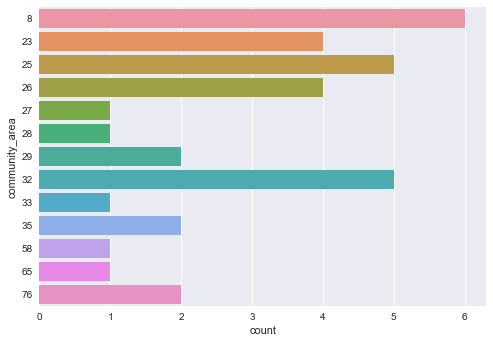

In [24]:
ax = sns.countplot(y="community_area", data=ca_dn_results)

One of the more interesting results so far. We needed to provide a very low support as well as confidence in order to get these results, but the lift of these rules are good and illustrate which communities are experiencing the most crime and what kind. We see that community area 25 appears to have the largest drug problem. Besides community 25, the surrounding communities of 23,26, and 29 have similar problems, making this one of the most problematic crime areas in Chicago. We see the community 8, the very touristy navy pier, has the most credit card fraud, retail theft, pick pocketing, and theft of goods and services. Finally, we see again the other weapons violation in the O'Hare community area, number 76, however again here we see a high rate of motor vehicle theft by lessee, which has high lift for similiar reasons, in that the context dictates an inordinate amount of car rental companies in and around the area. 

### 7. community area, location description

In [25]:
%%time
####### final formula for frequent itemset mining

# adjustable parameters:
dataframe_to_analyze = ca_ld
minimum_support = 0.0002
minimum_confidence = 0.15
minimum_lift = 3

# convert dataframe to consumable list of lists, apply apriori to identify frequent itemsets, and print results:
ca_ld_results = use_apriori(dataframe_to_analyze, minimum_support, minimum_confidence, minimum_lift)
print(ca_ld_results.shape[0], "rules found.")
print()

# display results
ca_ld_results.sort_values(by=['lift', 'confidence', 'support'], ascending=False)

#######

29 rules found.

CPU times: user 19.1 s, sys: 587 ms, total: 19.7 s
Wall time: 19.7 s


,rule,lift,confidence,support,location_description,community_area
28,['AIRPORT TERMINAL UPPER LEVEL - SECURE AREA'] ==> 76,165.195582,0.911487,0.000579,AIRPORT TERMINAL UPPER LEVEL - SECURE AREA,76
27,['AIRPORT TERMINAL LOWER LEVEL - NON-SECURE AREA'] ==> 76,163.193847,0.900442,0.000250,AIRPORT TERMINAL LOWER LEVEL - NON-SECURE AREA,76
25,['AIRPORT/AIRCRAFT'] ==> 76,147.022380,0.811214,0.001636,AIRPORT/AIRCRAFT,76
14,[54] ==> CHA APARTMENT,33.131958,0.151019,0.000674,CHA APARTMENT,54
6,['CHA HALLWAY/STAIRWELL/ELEVATOR'] ==> 33,31.779656,0.239841,0.000751,CHA HALLWAY/STAIRWELL/ELEVATOR,33
2,[54] ==> CHA PARKING LOT/GROUNDS,24.195393,0.167022,0.000746,CHA PARKING LOT/GROUNDS,54
24,['AIRPORT/AIRCRAFT'] ==> 56,21.272302,0.176139,0.000355,AIRPORT/AIRCRAFT,56
0,['CHA PARKING LOT/GROUNDS'] ==> 35,19.090630,0.212139,0.001464,CHA PARKING LOT/GROUNDS,35
3,['CHA HALLWAY/STAIRWELL/ELEVATOR'] ==> 35,17.533574,0.194837,0.000610,CHA HALLWAY/STAIRWELL/ELEVATOR,35
19,['COLLEGE/UNIVERSITY GROUNDS'] ==> 32,11.219508,0.272983,0.000224,COLLEGE/UNIVERSITY GROUNDS,32


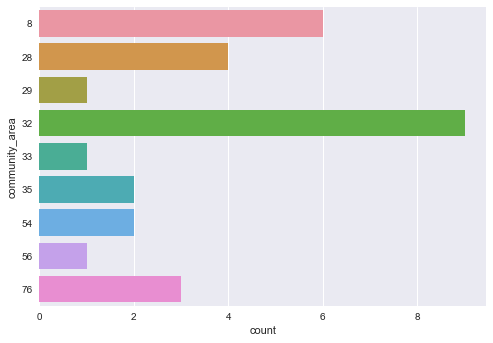

In [37]:
ax = sns.countplot(y="community_area", data=ca_ld_results)

Some of these results are especially interesting given what we learned in the last frequent itemset results. For example, we learned before how prevalent pickpocketing was in the navy pier area, but here we see that a lot of the crime being committed there is in restaurants and bars. This is a difficult thing to enforce by local police, but would be good information for local establishments to know.

### 8. community area, hour

In [26]:
%%time
####### final formula for frequent itemset mining

# adjustable parameters:
dataframe_to_analyze = ca_hr
minimum_support = 0.00001
minimum_confidence = 0.1
minimum_lift = 1

# convert dataframe to consumable list of lists, apply apriori to identify frequent itemsets, and print results:
ca_hr_results = use_apriori(dataframe_to_analyze, minimum_support, minimum_confidence, minimum_lift)
print(ca_hr_results)

# display results
#ca_hr_results.sort_values(by=['lift', 'confidence', 'support'], ascending=False)

#######

No results.
CPU times: user 20.6 s, sys: 653 ms, total: 21.3 s
Wall time: 21.3 s


Unsurprisingly given what we found in the project EDA, but disappointing nontheless, there appears to be no valid association rules between community area and the time of day. Perhaps notable in and of itself. 

### 9. community area, location description, crime code category

In [27]:
%%time
####### final formula for frequent itemset mining

# adjustable parameters:
dataframe_to_analyze = ld_ca_ccc
minimum_support = 0.0040
minimum_confidence = 0.1
minimum_lift = 3

# convert dataframe to consumable list of lists, apply apriori to identify frequent itemsets, and print results:
ld_ca_ccc_results = use_apriori(dataframe_to_analyze, minimum_support, minimum_confidence, minimum_lift)
print(ld_ca_ccc_results.shape[0], "rules found.")
print()

# display results
ld_ca_ccc_results.sort_values(by=['lift', 'confidence', 'support'], ascending=False)

#######

8 rules found.

CPU times: user 24 s, sys: 841 ms, total: 24.8 s
Wall time: 24.9 s


,rule,lift,confidence,support,crime_code_category,location_description,community_area
6,['RESIDENCE-GARAGE'] ==> Burglary,8.856286,0.505816,0.009495,Burglary,RESIDENCE-GARAGE,NaN
7,"[25, 'SIDEWALK'] ==> Drug Abuse",4.930013,0.468830,0.005493,Drug Abuse,SIDEWALK,25.0
5,['DEPARTMENT STORE'] ==> Larceny,3.866943,0.819444,0.010368,Larceny,DEPARTMENT STORE,NaN
3,['Prostitution'] ==> STREET,3.197930,0.819378,0.007665,Prostitution,STREET,NaN
0,['SIDEWALK'] ==> Drug Abuse,3.182014,0.302601,0.030520,Drug Abuse,SIDEWALK,NaN
1,['SIDEWALK'] ==> Robbery,3.149042,0.118870,0.011989,Robbery,SIDEWALK,NaN
2,['STREET'] ==> Motor Vehicle Theft,3.074678,0.139473,0.035736,Motor Vehicle Theft,STREET,NaN
4,['GROCERY FOOD STORE'] ==> Larceny,3.025541,0.641142,0.008058,Larceny,GROCERY FOOD STORE,NaN


Unlike many of the previous results, the number of results are quite limited by limiting the lift to 3, however the results we get are quite interesting and definitive of many of the trends we have been seeing so far. Drug abuse on the sidewalk continue to be tied to community area 25. Drug abuse and prostitution, two of the major crimes against society, continue to be tied to the sidewalk. Larceny in general and specifically retail theft is primarily tied to the department store and grocery store. New information is the link between residence garage and burglary, which as we saw earlier is primarily cases of forced entry. Also new information is that most motor vehicle theft is tied to the street, as opposed for example to a garage or residence. 

### 10. community area, crime against persons, crime against property, crime against society

In [28]:
%%time
####### final formula for frequent itemset mining

# adjustable parameters:
dataframe_to_analyze = ca_cape_capo_cas
minimum_support = 0.0050
minimum_confidence = 0.2
minimum_lift = 3

# convert dataframe to consumable list of lists, apply apriori to identify frequent itemsets, and print results:
ca_cape_capo_cas_results = use_apriori_simple(dataframe_to_analyze, minimum_support, minimum_confidence, minimum_lift)
print(ca_cape_capo_cas_results.shape[0], "rules found.")
print()

# display results
ca_cape_capo_cas_results.sort_values(by=['lift', 'confidence', 'support'], ascending=False)

#######

35 rules found.

CPU times: user 2min 54s, sys: 20.3 s, total: 3min 15s
Wall time: 3min 16s


,rule,lift,confidence,support
29,"[('community_area', 26), ('crime_against_society', True)] ==> ('crime_against_persons', False)",4.318122,0.986858,0.007569
33,"[('community_area', 27), ('crime_against_society', True)] ==> ('crime_against_persons', False)",4.304030,0.983637,0.006826
30,"[('community_area', 29), ('crime_against_society', True)] ==> ('crime_against_persons', False)",4.291849,0.980854,0.010004
28,"[('community_area', 25), ('crime_against_society', True)] ==> ('crime_against_persons', False)",4.288500,0.980088,0.022333
27,"[('community_area', 23), ('crime_against_society', True)] ==> ('crime_against_persons', False)",4.283292,0.978898,0.011055
26,"[('crime_against_society', True), ('community_area', 8)] ==> ('crime_against_persons', False)",4.253442,0.972076,0.005884
23,"[('community_area', 67), ('crime_against_society', True)] ==> ('crime_against_persons', False)",4.245683,0.970303,0.007515
20,"[('crime_against_society', True), ('community_area', 68)] ==> ('crime_against_persons', False)",4.233489,0.967516,0.006480
32,"[('community_area', 49), ('crime_against_society', True)] ==> ('crime_against_persons', False)",4.225141,0.965608,0.006471
34,"[('community_area', 28), ('crime_against_society', True)] ==> ('crime_against_persons', False)",4.221269,0.964723,0.005698


While we get quite a few results from this subset, they are not very interesting. By and large they just seem to say, that if we have a crime against a person it is not also a crime against society or property, and visa versa. There is some overlap between the crime against persons and crime against society categorizations, but otherwise this is what we would expect based on how they categorizations are designed. 

### 11. location description, crime against persons, crime against property, crime against society

In [29]:
%%time
####### final formula for frequent itemset mining

# adjustable parameters:
dataframe_to_analyze = ld_cape_capo_cas
minimum_support = 0.0045
minimum_confidence = 0.2
minimum_lift = 3

# convert dataframe to consumable list of lists, apply apriori to identify frequent itemsets, and print results:
ld_cape_capo_cas_results = use_apriori_simple(dataframe_to_analyze, minimum_support, minimum_confidence, minimum_lift)
print(ld_cape_capo_cas_results.shape[0], "rules found.")
print()

# display results
ld_cape_capo_cas_results.sort_values(by=['lift', 'confidence', 'support'], ascending=False)

#######

18 rules found.

CPU times: user 1min 49s, sys: 11.9 s, total: 2min 1s
Wall time: 2min 2s


,rule,lift,confidence,support
11,"[('crime_against_society', True), ('location_description', 'SIDEWALK')] ==> ('crime_against_persons', False)",4.319042,0.987068,0.041974
17,"[('crime_against_society', True), ('location_description', 'VEHICLE NON-COMMERCIAL')] ==> ('crime_against_persons', False)",4.287639,0.979891,0.004605
16,"[('crime_against_society', True), ('location_description', 'ALLEY')] ==> ('crime_against_persons', False)",4.276417,0.977327,0.008630
1,"[('crime_against_society', True)] ==> ('crime_against_persons', False)",4.217144,0.963781,0.228539
13,"[('crime_against_society', True)] ==> ('location_description', 'STREET')",4.217144,0.265068,0.062855
15,"[('location_description', 'OTHER'), ('crime_against_society', True)] ==> ('crime_against_persons', False)",4.205094,0.961027,0.006869
12,"[('crime_against_society', True), ('location_description', 'RESIDENCE')] ==> ('crime_against_persons', False)",4.006862,0.915723,0.037598
14,"[('location_description', 'APARTMENT'), ('crime_against_society', True)] ==> ('crime_against_persons', False)",3.960659,0.905164,0.015319
5,"[('crime_against_persons', True), ('location_description', 'STREET')] ==> ('crime_against_property', False)",3.869680,0.985285,0.044608
10,"[('crime_against_persons', True), ('location_description', 'RESIDENCE PORCH/HALLWAY')] ==> ('crime_against_property', False)",3.869649,0.985277,0.006879


In this subset we actually get some very interesting information. It may not be a huge surprise, but we see a very strong association telling us that if a crime is against society and it is on a sidewalk, in a non-commercial vehicle, or in an alley, then it is very likely also a crime against a person. This is significant in that only a few crime types fall into both the crimes against society and the crimes against persons categories. There are also quite a few other three itemset rules in these results that are interesting, warranting a deeper look at these results. 

### 12. weekend, crime against persons, crime against property, crime against society

In [30]:
%%time
####### final formula for frequent itemset mining

# adjustable parameters:
dataframe_to_analyze = wkn_cape_capo_cas
minimum_support = 0.0020
minimum_confidence = 0.2
minimum_lift = 3

# convert dataframe to consumable list of lists, apply apriori to identify frequent itemsets, and print results:
wkn_cape_capo_cas_results = use_apriori_simple(dataframe_to_analyze, minimum_support, minimum_confidence, minimum_lift)
print(wkn_cape_capo_cas_results.shape[0], "rules found.")
print()

# display results
wkn_cape_capo_cas_results.sort_values(by=['lift', 'confidence', 'support'], ascending=False)

#######

6 rules found.

CPU times: user 46.6 s, sys: 4.4 s, total: 51 s
Wall time: 51.3 s


,rule,lift,confidence,support
1,"[('crime_against_society', True)] ==> ('crime_against_persons', False)",4.217144,0.963781,0.228539
4,"[('crime_against_society', True)] ==> ('weekend', False)",4.217144,0.711960,0.168825
5,"[('crime_against_society', True)] ==> ('crime_against_persons', False)",4.217144,0.251821,0.059714
3,"[('crime_against_persons', True)] ==> ('weekend', True)",3.799317,0.298993,0.078697
0,"[('crime_against_persons', True)] ==> ('crime_against_property', False)",3.799317,0.967369,0.254617
2,"[('crime_against_persons', True)] ==> ('weekend', False)",3.799317,0.668376,0.175920


While any association rules between a 'crimes against * ' category and another 'crimes against * ' category are essentially worthless when put into context, any association rules between these categorizations and the weekend group could be interesting. Here we see that if a crime is against society or property, most likely it is not on the weekend. That is not surprising given there are five weekdays and two weekend days in a week, so is what we expect. Perhaps surprising though is that if a crime against persons is committed, our rule has a 3.799317 lift that it will be on the weekend. This is the first association rule so far that has provided any kind of indication when a kind of crime will be committed. Further analysis would include mining for frequent itemsets by crime type category belong only to crimes against persons alongside the weekend attribute to hopefully determine which crimes specifically occur most on the weekend. Likely this could be explored further as well using any other data mining technique or regular statistical analysis. 

### 13. hour, crime against persons, crime against property, crime against society

In [31]:
%%time
####### final formula for frequent itemset mining

# adjustable parameters:
dataframe_to_analyze = hr_cape_capo_cas
minimum_support = 0.01
minimum_confidence = 0.2
minimum_lift = 3

# convert dataframe to consumable list of lists, apply apriori to identify frequent itemsets, and print results:
hr_cape_capo_cas_results = use_apriori_simple(dataframe_to_analyze, minimum_support, minimum_confidence, minimum_lift)
print(hr_cape_capo_cas_results.shape[0], "rules found.")
print()

# display results
hr_cape_capo_cas_results.sort_values(by=['lift', 'confidence', 'support'], ascending=False)

#######

31 rules found.

CPU times: user 2min 32s, sys: 15.4 s, total: 2min 47s
Wall time: 2min 48s


,rule,lift,confidence,support
30,"[('crime_against_society', True), ('hour', 23)] ==> ('crime_against_persons', False)",4.286690,0.979675,0.011649
23,"[('hour', 22), ('crime_against_society', True)] ==> ('crime_against_persons', False)",4.285730,0.979455,0.014731
28,"[('hour', 21), ('crime_against_society', True)] ==> ('crime_against_persons', False)",4.282980,0.978827,0.016216
18,"[('hour', 20), ('crime_against_society', True)] ==> ('crime_against_persons', False)",4.270995,0.976088,0.016815
24,"[('hour', 11), ('crime_against_society', True)] ==> ('crime_against_persons', False)",4.268575,0.975535,0.012645
26,"[('hour', 19), ('crime_against_society', True)] ==> ('crime_against_persons', False)",4.265655,0.974867,0.016479
19,"[('hour', 13), ('crime_against_society', True)] ==> ('crime_against_persons', False)",4.249636,0.971206,0.012262
29,"[('hour', 10), ('crime_against_society', True)] ==> ('crime_against_persons', False)",4.235581,0.967994,0.010312
25,"[('crime_against_society', True), ('hour', 14)] ==> ('crime_against_persons', False)",4.225943,0.965792,0.011938
20,"[('crime_against_society', True), ('hour', 12)] ==> ('crime_against_persons', False)",4.224100,0.965370,0.013963


Easily the least informative results so far. The inputs have been constricted to show a sample of the results, but even when parameters are relaxed significantly there appears to be no interesting associations between these crime type categories and the hour, which is what we are looking for here. 

### 14. arrest, domestic crime, index crime (more serious crime), violent crime

In [32]:
%%time
####### final formula for frequent itemset mining

# adjustable parameters:
dataframe_to_analyze = arr_dom_idx_vc
minimum_support = 0.0008
minimum_confidence = 0.2
minimum_lift = 3

# convert dataframe to consumable list of lists, apply apriori to identify frequent itemsets, and print results:
arr_dom_idx_vc_results = use_apriori_simple(dataframe_to_analyze, minimum_support, minimum_confidence, minimum_lift)
print(arr_dom_idx_vc_results.shape[0], "rules found.")
print()

# display results
arr_dom_idx_vc_results.sort_values(by=['lift', 'confidence', 'support'], ascending=False)

#######

5 rules found.

CPU times: user 59.4 s, sys: 7.63 s, total: 1min 7s
Wall time: 1min 7s


,rule,lift,confidence,support
4,"[('violent_crime', True), ('arrest', True)] ==> ('domestic', True)",11.849973,0.206081,0.003216
1,"[('domestic', True), ('index_crime', True)] ==> ('violent_crime', True)",7.457928,0.648396,0.011276
2,"[('domestic', True), ('index_crime', True)] ==> ('violent_crime', True)",6.497224,0.463490,0.008060
0,"[('index_crime', True), ('arrest', True)] ==> ('violent_crime', True)",3.798704,0.330261,0.015604
3,"[('index_crime', True), ('arrest', True)] ==> ('domestic', False)",3.465313,0.262201,0.012388


These results are informative and succinct. They tell us that if a crime is violent it typically leads to an arrest. This is good to know, given that most crime does not lead to an arrest and most crime is not violent, so such a strong association here is very telling that these two things are related. Maybe less obvious, we see also that domestic crime in and of itself does not typically lead to an arrest, however when it is of the index_crime variety that typically means it is violent, which we know does lead to arrest usually. This is interesting because in the same results we also see that when a crime is an index crime and there is an arrest, it is not likely to be a domestic crime. This says that the previous rule is rare, which we see by its very low support, but has a very high lift signifying that when it does happen, it is strongly enforced. 

### 15. community area, crime against persons, crime against property, crime against society

In [33]:
%%time
####### final formula for frequent itemset mining

# adjustable parameters:
dataframe_to_analyze = ca_cape_capo_cas_arr
minimum_support = 0.03
minimum_confidence = 0.2
minimum_lift = 3

# convert dataframe to consumable list of lists, apply apriori to identify frequent itemsets, and print results:
ca_cape_capo_cas_arr_results = use_apriori_simple(dataframe_to_analyze, minimum_support, minimum_confidence, minimum_lift)
print(ca_cape_capo_cas_arr_results.shape[0], "rules found.")
print()

# display results
ca_cape_capo_cas_arr_results.sort_values(by=['lift', 'confidence', 'support'], ascending=False)

#######

8 rules found.

CPU times: user 45 s, sys: 4.96 s, total: 49.9 s
Wall time: 50 s


,rule,lift,confidence,support
1,"[('crime_against_society', True)] ==> ('crime_against_persons', False)",4.217144,0.963781,0.228539
7,"[('crime_against_society', True)] ==> ('crime_against_persons', False)",4.217144,0.683963,0.162186
6,"[('crime_against_society', True)] ==> ('crime_against_persons', False)",4.217144,0.279818,0.066352
0,"[('crime_against_persons', True)] ==> ('crime_against_property', False)",3.799317,0.967369,0.254617
4,"[('crime_against_persons', True)] ==> ('crime_against_property', False)",3.799317,0.749137,0.197177
5,"[('crime_against_persons', True)] ==> ('crime_against_property', False)",3.799317,0.218232,0.057440
2,"[('crime_against_society', True)] ==> ('crime_against_persons', False)",3.236167,0.683963,0.162186
3,"[('crime_against_society', True)] ==> ('crime_against_property', False)",3.124087,0.692328,0.164170


As we can see, the crime against * category does not give us any clue as to what part of the city these are being committed in, just as it did not tell us what hour they were being committed in. Given how general these categorizations are, that is not very surprising.  

### 16. community area, arrest, domestic crime, index crime, violent crime. 

In [34]:
%%time
####### final formula for frequent itemset mining

# adjustable parameters:
dataframe_to_analyze = ca_arr_dom_idx_vc
minimum_support = 0.01
minimum_confidence = 0.2
minimum_lift = 2

# convert dataframe to consumable list of lists, apply apriori to identify frequent itemsets, and print results:
ca_arr_dom_idx_vc_results = use_apriori_simple(dataframe_to_analyze, minimum_support, minimum_confidence, minimum_lift)
print(ca_arr_dom_idx_vc_results.shape[0], "rules found.")
print()

# display results
ca_arr_dom_idx_vc_results.sort_values(by=['lift', 'confidence', 'support'], ascending=False)

#######

13 rules found.

CPU times: user 5min 28s, sys: 55.3 s, total: 6min 23s
Wall time: 6min 32s


,rule,lift,confidence,support
4,"[('domestic', True), ('index_crime', True)] ==> ('violent_crime', True)",7.457928,0.648396,0.011276
2,"[('index_crime', True), ('arrest', True)] ==> ('violent_crime', True)",3.798704,0.330261,0.015604
9,"[('index_crime', True), ('arrest', True)] ==> ('domestic', False)",3.465313,0.262201,0.012388
0,"[('index_crime', True)] ==> ('violent_crime', True)",2.481780,0.215767,0.086941
1,"[('violent_crime', True)] ==> ('index_crime', True)",2.306849,0.820522,0.071337
3,"[('violent_crime', True)] ==> ('domestic', False)",2.257320,0.870300,0.075664
7,"[('domestic', False), ('index_crime', False), ('community_area', 23)] ==> ('arrest', True)",2.174427,0.588776,0.010276
8,"[('domestic', False), ('community_area', 25), ('index_crime', False)] ==> ('arrest', True)",2.162134,0.585448,0.020448
5,"[('violent_crime', True)] ==> ('domestic', False)",2.128078,0.727809,0.063276
6,"[('index_crime', False), ('arrest', False)] ==> ('domestic', True)",2.054653,0.255014,0.095257


Unfortunately, these boolean values are largely as unfruitful as the last, however there are a few interesting observations to be made. We se that if a crime is not domestic and not an index crime in community area 25 or 23, it is likely to lead to an arrest. Given what we know about these categorizations so far, that is not common. This could in due be a result of the drug problems in that area, or perhaps a result of the demographics. Understanding why this trend is occcuring here could uncover some bias in the policing, or reveal more information about the endemic crime problem in area 25 and 23. 

### 17. crime code category, hour, year, month, day of the week, ward

In [35]:
%%time
#######

# adjustable parameters:
dataframe_to_analyze = ccc_hr_yr_mon_dow_wd
minimum_support = 0.001
minimum_confidence = 0.01
minimum_lift = 2.5

# convert dataframe to consumable list of lists, apply apriori to identify frequent itemsets, and print results:
ccc_hr_yr_mon_dow_wd_results = use_apriori(dataframe_to_analyze, minimum_support, minimum_confidence, minimum_lift)
print(ccc_hr_yr_mon_dow_wd_results.shape[0], "rules found.")
print()

# display results
ccc_hr_yr_mon_dow_wd_results.sort_values(by=['lift', 'confidence', 'support'], ascending=False)

#######

28 rules found.

CPU times: user 12min 49s, sys: 5.23 s, total: 12min 54s
Wall time: 13min 1s


,rule,lift,confidence,support,crime_code_category,ward,hour,dayofweek,month,year
3,['Drug Abuse'] ==> 19,3.653417,0.010526,0.001001,Drug Abuse,28.0,19.0,NaN,NaN,NaN
23,[42.0] ==> 2017,3.533647,0.034522,0.001418,Larceny,42.0,NaN,NaN,NaN,2017.0
22,[42.0] ==> 2018,3.476324,0.034196,0.001404,Larceny,42.0,NaN,NaN,NaN,2018.0
11,[42.0] ==> 13,3.429694,0.040644,0.001669,Larceny,42.0,13.0,NaN,NaN,NaN
17,[42.0] ==> 17,3.368990,0.043398,0.001782,Larceny,42.0,17.0,NaN,NaN,NaN
21,[42.0] ==> 2019,3.340394,0.031656,0.001300,Larceny,42.0,NaN,NaN,NaN,2019.0
15,[42.0] ==> Larceny,3.219034,0.040363,0.001657,Larceny,42.0,14.0,NaN,NaN,NaN
1,['Fraud'] ==> 42.0,3.192046,0.131072,0.004473,Fraud,42.0,NaN,NaN,NaN,NaN
10,[42.0] ==> 16,3.159178,0.039813,0.001635,Larceny,42.0,16.0,NaN,NaN,NaN
13,[42.0] ==> 15,3.078176,0.040846,0.001677,Larceny,42.0,15.0,NaN,NaN,NaN


Due to the relatively low occurrence of itemsets in this data subset and the high volume of Larceny in our dataset overall, we had to significantly lower the support, raise the lift, and fine tune the confidence in order to still get meaningful results. The same was true for the next subset of data, where the only different attribute was using community area instead of ward. In our results, we see that ward 42 and ward 28 feature prominently. The majority of itemsets include either Larceny or Drug Abuse, which we would expect given those are the most frequent crimes, but for the first time we find relatively strong associations with specific hours. The strongest is in ward 28, where drug abuse crimes are most likely to take place at hour 19 (7pm). The next most likely hour for a crime to be drug abuse in community 28 is hour 28 (4am). Ward 42, on the other hand, is dominated by larceny crimes at almost all hours, but primarily 12 - 18. The last piece of really interesting information is that larceny in ward 42 is especially associated with years 2017, 2018, and 2019. This is valuable information, since we know crime has plateaued in recent years in part due to increased larceny, but had not yet found where that was especially the case. Finally, the only appearance prostitution has in these results is alongside ward 28, which is also good to know given that is a much less frequent crime, which emphasized that this association is real and less likely to do with simply being the result of it being popular crime. 

### 18. crime code category, hour, year, month, day of week, community area

In [36]:
%%time
#######

# adjustable parameters:
dataframe_to_analyze = ccc_hr_yr_mon_dow_ca
minimum_support = 0.001
minimum_confidence = 0.01
minimum_lift = 2.5

# convert dataframe to consumable list of lists, apply apriori to identify frequent itemsets, and print results:
ccc_hr_yr_mon_dow_ca_results = use_apriori(dataframe_to_analyze, minimum_support, minimum_confidence, minimum_lift)
print(ccc_hr_yr_mon_dow_ca_results.shape[0], "rules found.\n")

# display results
ccc_hr_yr_mon_dow_ca_results.sort_values(by=['lift', 'confidence', 'support'], ascending=False)

#######

25 rules found.

CPU times: user 12min 25s, sys: 7.95 s, total: 12min 33s
Wall time: 13min 6s


,rule,lift,confidence,support,crime_code_category,community_area,month,hour,year,dayofweek
15,[32] ==> 13,4.086091,0.048422,0.001178,Larceny,32.0,NaN,13.0,NaN,NaN
18,[32] ==> Larceny,3.521330,0.044153,0.001074,Larceny,32.0,NaN,14.0,NaN,NaN
19,[32] ==> 17,3.520319,0.045347,0.001103,Larceny,32.0,NaN,17.0,NaN,NaN
14,[32] ==> 16,3.396366,0.042802,0.001041,Larceny,32.0,NaN,16.0,NaN,NaN
16,[32] ==> Larceny,3.362423,0.049875,0.001214,Larceny,32.0,NaN,12.0,NaN,NaN
17,[32] ==> 15,3.286049,0.043604,0.001061,Larceny,32.0,NaN,15.0,NaN,NaN
3,['Fraud'] ==> 32,3.034056,0.073822,0.002520,Fraud,32.0,NaN,NaN,NaN,NaN
5,['Drug Abuse'] ==> 19,2.986240,0.011206,0.001066,Drug Abuse,25.0,NaN,19.0,NaN,NaN
1,['Misc Non-Index Offense'] ==> 76,2.825541,0.015590,0.001562,Misc Non-Index Offense,76.0,NaN,NaN,NaN,NaN
24,[3] ==> 6,2.763734,0.071167,0.001539,Simple Battery,NaN,NaN,3.0,NaN,6.0


Using the same subset of data but replacing ward with community area, we confirm many of the patterns identified before given that the same community areas appearing here are within the wards just mentioned. Area 32, downtown area where the malls or focused and includes many larceny type crimes. Once again we see the most found hours where this is occuring is between 12 and 17. Drug abuse is still ocurring at 19 (7pm) in community area 25, but here we actually see some year data on community 25. 2003, 2006, and 2007 all show up, calling into question whether the major drug abuse issues we have seen so far associated with the community areas in the mid-twenties all grouped together on the west side is still current. 

# Key Takeaways
While our original exploratory data analysis revealed that larceny, battery, criminal damages, and drug abuse were the four most prevalent crimes, by employing frequent data mining we learned that drug abuse and larceny were focalized in several regions. Drug abuse is associated with community areas 23, 25, 26, and 29, or Humboldt Park, Austin, West Garfield Park, and North Lawndale, respectively. Drug abuse in these areas is most heavily associated with 2003, 2006, and 2007. Historically these communities have a history of violence and gang activity, which the prevalence of drug abuse indicates. If there is a larceny, there is a good chance it is in community area 32, or "The Loop", Chicago's central business district and heart of downtown. Perhaps more interesting, we learned that crimes in this area are most associated with the hours between noon and 5pm. Just next door, in the Near North Side where the Navy Pier and many other tourist attractions exist, pickpocketing, credit card fraud, retail theft, and fraud are also heavily associated with the area. This is especially interesting when we consider the new information that besides the typical department stores and small business stores, a lot of the crimes in these areas are occuring in bars or taverns, restaurants, and hotels, indicating that a lot of this crime is linked to the tourists in the area. 

Departing from these favorite areas of major crime, we also identified the primary sources of several non-major crime. In some cases, these associations turned out to be in large part due to biases in the data, but not all. Where there is a crime for prostitution, our association rule says that it will be in community area 28, or the Near West Side. This area is large and lies between the previously mentioned trouble area of 23, 25, 26, and 29 and The Loop, or downtown Chicago. The area has a long history of crime dating back at least to the 70's, but has undergone a lot of redevelopment since the early 2000's, so it is an outstanding question what the cause of the ties to prostitution there are, or whether it is an artifact from the earlier years in our data. That answer would require further discover. Perhaps the strongest assocation we found anywhere in the data set was the link between "Other Weapon Violation" and community area 76. As it turns out, the community area is O'Hare, where the airport is located. We speculated that this could be the result of people attempting to carry disallowed items onto planes, which required its own description given that not all of those items would be considered weapons in a different context and likewise would not necessarily be a crime anywhere else, leading to an extremely high correlation between this description and location. This was more or less confirmed by the later assocation rule telling us that, if there is a crime in O'Hare, it is extremely likely that it occured in either the Upper or Lower Terminal of the airport. A similiar biased association to this that we found was a very strong correlation between auto theft by lessee and the O'Hare area, which obviously points to the fact that this is where the majority of car rental locations will be. 

Aside from specific community areas, we also found some potentially interesting associations between location descriptions and various types of crime, as well as other location types. Most obvious was the prevalence of larceny taking place in department stores, in particular the Loop area, but also throughout Chicago. Perhaps just as obvious was the high association with drug abuse occuring on sidewalks. This becomes a bit more interesting considering that drug abuse on the sidewalk is heavily associated with community area 25, taken in conjunction with the fact that sidewalk crime alone is heavily associated with the West Ferdinand St block, which tracks laterally through the Humboldt and West Garfield park areas. Taking these rules together begins to paint a picture of the drug abuse crime and homelessness issues in the area and where exactly they are focalized in the community that could be very helpful not only for law enforcement, but also community organizers and support groups looking to provide relief and uplift the community. We also found that if a crime is committed in a residence garage, it is most likely to be a burglary. What we also found was that of all crime committed in garages, most were described as "forced entries". At face value this may be obvious, but again helps to paint a picture of how and where these crimes are being committed that could be useful not only to law enforcement, but individuals or security companies looking how best to protect peoples homes, who can now say that gargages are the most vulnerable places to break ins. Finally, there were what we considered a surprising amount of crimes associated with hallways, stairwells, elevators, and apartments occuring in the community area 28. This is the same Near West Side where prostitution is most likely to take place. In general, crime appears to be most common on the street in Chicago, except where larceny is taking place in department stores and grocery stores, however here it seems that there are far more crimes being reported here off the street and inside buildings. Given the history of crime in projects in this area, it is reasonable to suspect that many of the apartment complexes in the area are a root cause for this. Speaking of apartment crime, we also found an alarming set of almost identical crime associations with apartments along the st blocks of E 68th St, E 70th St, E 78th St, E 80th St, E 81st St, E 82nd St, and S South Shore Dr. All of these blocks run through the South Chicago and Avalon Park neighborhoods, which until this point have not shown up in our frequent itemset mining. We believe this would be another great entrypoint for additional discovery. 

Finally, besides mining the more specific attributes for insights, we also took a look at the broader categorical attributes in an attempt to gain broad stroke information that might lead to further analysis. Mining these attributes is particularly difficult because of the need to significantly lower support and raise lift while fine tuning the confidence inputs in order to filter out the high number of uninteresting matches, however we did find a few useful pieces of information. We found that in ward 28, the drug abuse crimes were more most likely to occurr at 7pm and 4am. We also found that larceny in ward 42 is especially associated with years 2017, 2018, and 2019, which is significant given the large role larceny has proven to show in the plateau of crime in the last four years as well as the fact that this is some of the only year data itemsets specifically showing recent years in the results. We also found that in community areas 25 and 23, non-index, non-domestic crime is likely to lead to an arrest, which is very surprising because in all other areas domestic crime that is non-index is strongly associated with a non-arrest, whilst domestic crime that is index crime is strongly associated with arrests, indicating that domestic crime is normally strongly split based on the severity of the crime type whether it will results in an arrest or not. The bucking of this trend as well as the bucking of the trend in general that most non-index crimes do not results in arrests is notable, becuase it indicates stricter law enforcement in the area. Another interesting piece of information we found that we did not expect was that while a crime against property or society could be expected to occur on a weekday, which we assume given there are more weekdays than weekend days, if it is a crime against a person we have an association rule with fairly high lift telling us it will be on the weekend. Crimes against persons include homicide, involuntary manslaught, criminal sexual assault, aggravated assault and battery, simple assault and battery, criminal sexual abuse, and offenses against family. Crimes against persons has the largest share of the three of both index (more serious) and violent crime. Given this rule, it is safe to say that generally speaking, the weekend is more dangerous than the weekday. 

### Future work:
All of the results we have found so far were based on frequent mining the entire dataset. A major issue of this is that the most popular crimes tend to dominate the results even when we do our best to filter them out by raising lift and attempt to include less common crimes by lowering the support. By using some the findings we have shown here to downsample the data further, for example by omitting larceny or by reducing our data to a subset of years, more detailed analysis using frequent itemset mining can still be done. That is not to mention the many other combinations of attribute subsets including the entire data set that we were not able to include here. It would take a tremendous amount of work to exhaust all of these options. Furthermore, while many of the results here are interesting, they often do not tell the whole story. Specific statistical analysis would need to be done on each results to further interpret the findings and 1. validate what we have found, and 2. gain more insight into the cause and potential solutions for those findings. 

# SANDBOX
Use this space to apply apriori method to any one of the data subsets we have provided or any that you would prefer to define yourself. Tweak the parameters to explore different results and make judgements on their validity based on what you know about the inputs as they relate to the data. 